<h1 style="color:#3a7aad">Traffic Light Detection</h1>

<h2 style="color:#3a7aad">Dataset Reference</h2>

* https://github.com/vatsl/TrafficLight_Detection-TensorFlowAPI

<h2 style="color:#3a7aad">Code Reference</h2>

* https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

In [1]:
# !pip install --no-deps keras==2.2.4
# !pip install PyDrive
# !pip install mrcnn
# !pip install keras_applications
# !pip install --upgrade pyyaml
# !pip uninstall -y tensorflow
# !pip install tensorflow-gpu==1.15.3

In [2]:
import os
import yaml
import pprint
import matplotlib.pyplot as plt
import cv2

In [3]:
# use_tpu = True #@param {type:"boolean"}

# if use_tpu:
#     assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

# if 'COLAB_TPU_ADDR' in os.environ:
#   TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
# else:
#   TF_MASTER=''

In [4]:
# %tensorflow_version 1.15x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
with open("/content/drive/My Drive/Colab Notebooks/traffic light detector/dataset-sdcnd-capstone/data/sim_training_data/sim_data_annotations.yaml", "r") as yamlfile:
    data = yaml.load(yamlfile, Loader=yaml.FullLoader)
    print("Read successful")
    print(f"Located {len(data)} annotations")

Read successful
Located 277 annotations


<h2 style="color:#3a7aad">Sample Annotation</h2>

In [7]:
selected_index = 20
pp = pprint.PrettyPrinter(width=41, compact=True)
pp.pprint(data[selected_index])

{'annotations': [{'class': 'Red',
                  'x_width': 70.08,
                  'xmin': 43.84,
                  'y_height': 162.24,
                  'ymin': 149.76},
                 {'class': 'Red',
                  'x_width': 72.0,
                  'xmin': 379.52,
                  'y_height': 168.64000000000001,
                  'ymin': 153.28},
                 {'class': 'Red',
                  'x_width': 72.00000000000011,
                  'xmin': 721.92,
                  'y_height': 167.67999999999998,
                  'ymin': 158.08}],
 'class': 'image',
 'filename': 'sim_data_capture/left0030.jpg'}


<h2 style="color:#3a7aad">Sample Image</h2>

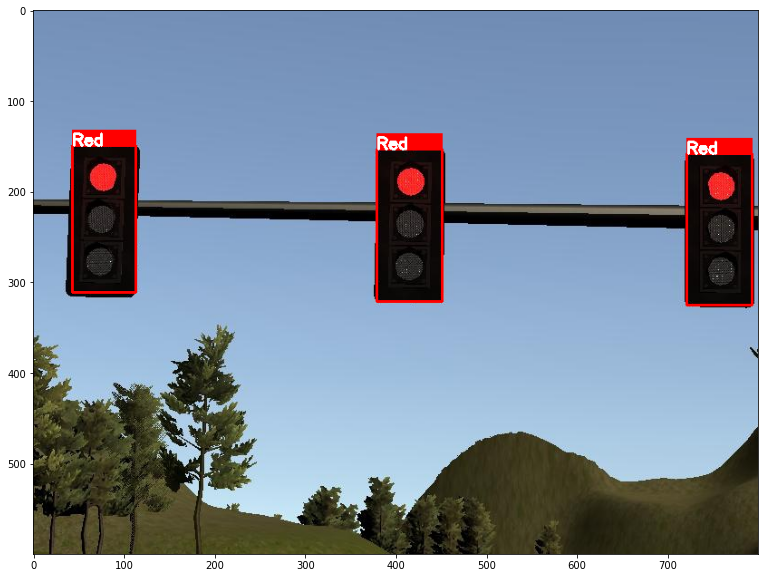

In [8]:
image_sample = cv2.imread(f"/content/drive/My Drive/Colab Notebooks/traffic light detector/dataset-sdcnd-capstone/data/sim_training_data/{data[selected_index]['filename']}")
image_sample = cv2.cvtColor(image_sample, cv2.COLOR_BGR2RGB)

for i in range(len(data[selected_index]['annotations'])):
    w = int(data[selected_index]['annotations'][i]['x_width'])
    h = int(data[selected_index]['annotations'][i]['y_height'])
    
    x = int(data[selected_index]['annotations'][i]['xmin'])
    y = int(data[selected_index]['annotations'][i]['ymin'])
    
    label = data[selected_index]['annotations'][i]['class']

    cv2.rectangle(image_sample, (x, y), (x+w, y+h), (255, 0, 0), 2)
    cv2.rectangle(image_sample, (x, y), (int(x+w), int(y-0.1*h)), (255, 0, 0), -1)
    cv2.putText(image_sample, label, (x, y), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, 
                (255, 255, 255), 2)

plt.figure(figsize=(15,10))
plt.imshow(image_sample)

In [9]:
filenames = []
for i in range(len(data)):
    filenames.append(int(data[i]['filename'][-8:-4]))

In [21]:
import yaml
import cv2
import os
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import warnings

warnings.filterwarnings('ignore')

gdrive_path = '/content/drive/My Drive/Colab Notebooks/traffic light detector/'
 
# class that defines and loads the kangaroo dataset
class TrafficLightDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "Red")
        self.add_class("dataset", 2, "Green")
        self.add_class("dataset", 3, "Yellow")
        
        images_dir = gdrive_path + 'dataset-sdcnd-capstone/data/sim_training_data/'
        
        data = self.read_annotations()
        filenames = self.get_filenames(data)
        
        # find all images
        for index, filename in enumerate(filenames):
            image_id = filename[-8:-4]
            # skip all images after 200 if we are building the train set
            if is_train and index >= 200:
                continue
            # skip all images before 200 if we are building the test/val set
            if not is_train and index < 200:
                continue
            img_path = images_dir + filename
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=data[index])
            
    def read_annotations(self):
        with open(gdrive_path + "dataset-sdcnd-capstone/data/sim_training_data/sim_data_annotations.yaml", "r") as yamlfile:
            data = yaml.load(yamlfile, Loader=yaml.FullLoader)
            print("Read successful")
            print(f"Located {len(data)} annotations")
        return data
    
    def get_filenames(self, data):
        filenames = []
        for i in range(len(data)):
            filenames.append(data[i]['filename'])
        return filenames
 
    # extract bounding boxes from an annotation file
    def extract_boxes(self, node):
        # extract each bounding box
        boxes = []
        for annotation in node['annotations']:
            xmin = int(annotation['xmin'])
            ymin = int(annotation['ymin'])
            xmax = int(annotation['x_width']) + xmin
            ymax = int(annotation['y_height']) + ymin
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        image = cv2.imread(f'{gdrive_path}dataset-sdcnd-capstone/data/sim_training_data/{node["filename"]}')
        width = image.shape[1]
        height = image.shape[0]
        return boxes, width, height
 
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        annotation_node = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(annotation_node)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            if annotation_node['annotations'][i]['class'].lower() == 'green':
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Green'))
            elif annotation_node['annotations'][i]['class'].lower() == 'red':
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('Red'))
            elif annotation_node['annotations'][i]['class'].lower() == 'yellow':
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('Yellow'))
        return masks, asarray(class_ids, dtype='int32')
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
 
# define a configuration for the model
class TrafficConfig(Config):
    # define the name of the configuration
    NAME = "traffic_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 3
    # number of training steps per epoch
    STEPS_PER_EPOCH = 131
 
# prepare train set
train_set = TrafficLightDataset()
train_set.load_dataset('traffic', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = TrafficLightDataset()
test_set.load_dataset('traffic', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config
config = TrafficConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights(gdrive_path + 'weights/mask_rcnn_coco.h5', by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

Read successful
Located 277 annotations
Train: 200
Read successful
Located 277 annotations
Test: 77

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mas

In [26]:
!ls

drive			  traffic_cfg20201226T1741  traffic_cfg20201226T1825
model_detect.h5		  traffic_cfg20201226T1742  traffic_cfg20201226T1827
sample_data		  traffic_cfg20201226T1808
traffic_cfg20201226T1740  traffic_cfg20201226T1809


In [48]:
# define the prediction configuration
class PredictionConfig(Config):
  # define the name of the configuration
  NAME = "traffic_cfg"
  # number of classes (background + lights)
  NUM_CLASSES = 1 + 3
  # simplify GPU config
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  BATCH_SIZE = 1

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

In [49]:
# load model weights
model.load_weights('./traffic_cfg20201226T1827/mask_rcnn_traffic_cfg_0005.h5', by_name=True)

Re-starting from epoch 5


In [119]:
from google.colab import files
files.download('./traffic_cfg20201226T1827/mask_rcnn_traffic_cfg_0005.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

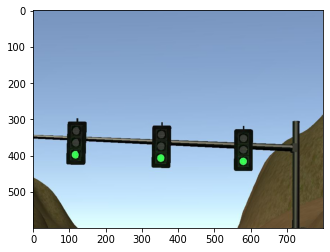

In [116]:
image_sample = cv2.imread(f"/content/drive/My Drive/Colab Notebooks/traffic light detector/dataset-sdcnd-capstone/data/sim_training_data/{data[200]['filename']}")
image_sample = cv2.cvtColor(image_sample, cv2.COLOR_BGR2RGB)
plt.imshow(image_sample)

In [117]:
yhat = model.detect([image_sample], verbose=0)
print(yhat[0]['rois'])
print(yhat[0]['scores'])
print(yhat[0]['class_ids'])

[[332 555 441 606]
 [312  94 417 144]
 [323 328 434 380]]
[0.9042734 0.9009785 0.8793965]
[2 2 2]


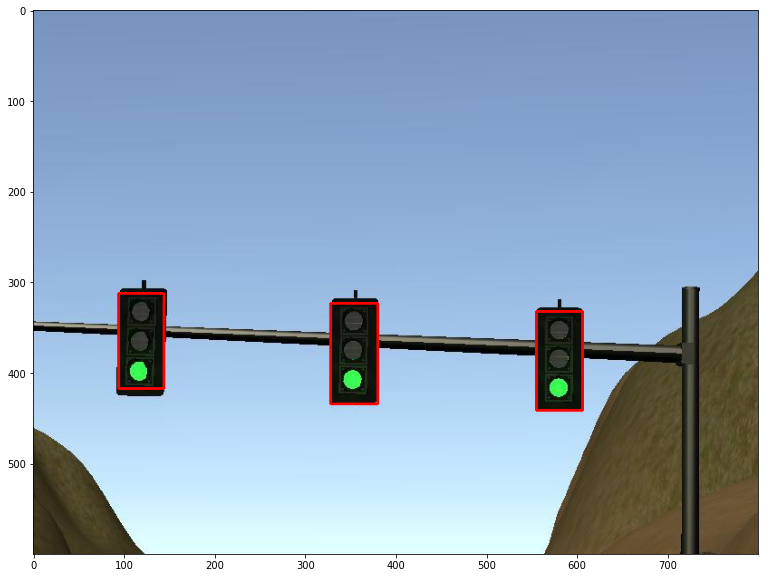

In [118]:
image_sample = cv2.imread(f"/content/drive/My Drive/Colab Notebooks/traffic light detector/dataset-sdcnd-capstone/data/sim_training_data/{data[200]['filename']}")
image_sample = cv2.cvtColor(image_sample, cv2.COLOR_BGR2RGB)

boxes = yhat[0]['rois']
for box in boxes:
  cv2.rectangle(image_sample, (box[3], box[2]), (box[1], box[0]), (255, 0, 0), 2)

plt.figure(figsize=(15,10))
plt.imshow(image_sample)

In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture('video.avi')

current_state = False
annotation_list = []

while(True):
    # Read one frame.
    ret, frame = cap.read()
    if not ret:
        break

    # Show one frame.
    cv2.imshow('frame', frame)

    # Check, if the space bar is pressed to switch the mode.
    if cv2.waitKey(1) & 0xFF == ord(' '):
        current_state = not current_state

    annotation_list.append(current_state)

# Convert the list of boolean values to a list of int values.    
annotation_list = map(int, annotation_list)
print annotation_list

cap.release()
cv2.destroyAllWindows()